In [36]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import cv2
import skimage

In [300]:
folder_pth = 'local_debugging/'
output = np.load(folder_pth + 'output.npy')
otsu = np.load(folder_pth + 'otsu.npy')
hysteresis = np.load(folder_pth + 'hysteresis.npy')
fill = np.load(folder_pth + 'fill.npy')

In [3]:
# gray = cv2.cvtColor(output, cv2.COLOR_BGR2GRAY)
# ret, thresh = cv2.threshold(gray,0,255,cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU)
# ret, thresh = cv2.threshold(gray,0,255,cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU)
# plt.imshow(ret)

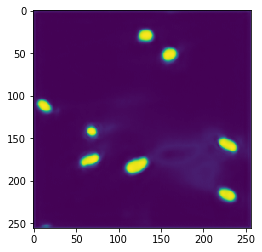

In [4]:
plt.imshow(output)

In [117]:
thresh = skimage.filters.threshold_otsu(output)

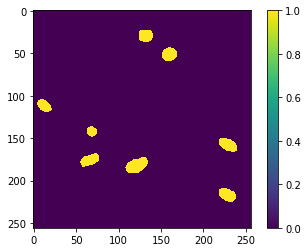

In [132]:
plt.imshow(otsu)
plt.colorbar()

## Watershed start

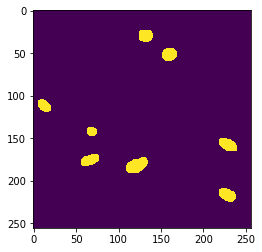

In [356]:
# noise removal
kernel = np.ones((3,3),np.uint8)
opening = cv2.morphologyEx(otsu.astype(np.uint8), cv2.MORPH_OPEN, kernel, iterations = 2)

# sure background area
sure_bg = cv2.dilate(opening, kernel, iterations=3)
plt.imshow(opening)

In [357]:
# Finding sure foreground area
dist_transform = cv2.distanceTransform(opening, cv2.DIST_L2, 5)
ret, sure_fg = cv2.threshold(dist_transform, 1.0*dist_transform.mean(), 255, 0)

# Finding unknown region
sure_fg = np.uint8(sure_fg)
unknown = cv2.subtract(sure_bg,sure_fg)

In [358]:
# Marker labelling
ret, markers = cv2.connectedComponents(sure_fg)
# Add one to all labels so that sure background is not 0, but 1
markers = markers+1
# Now, mark the region of unknown with zero
markers[unknown==255] = 0

1


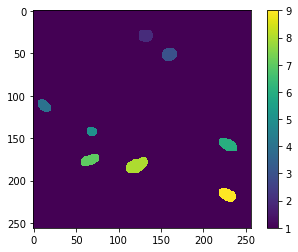

In [359]:
plt.imshow(markers)
plt.colorbar()
print(markers[0,0])

/Users/josephmurphy/anaconda/lib/python3.5/site-packages/skimage/util/dtype.py:110: UserWarning: Possible precision loss when converting from float32 to uint8
  "%s to %s" % (dtypeobj_in, dtypeobj))


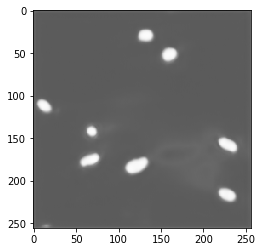

In [360]:
output_3chan = skimage.color.gray2rgb(output)
output_3chan = skimage.img_as_ubyte(output_3chan)
plt.imshow(output_3chan)

In [361]:
# Watershed call
markers = cv2.watershed(output_3chan, markers)
output_3chan[markers == -1] = [255,0,0]

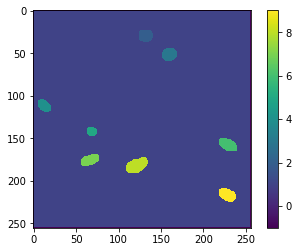

In [362]:
plt.imshow(markers)
plt.colorbar()

In [363]:
markers = np.where(markers == 1, 0, 1)

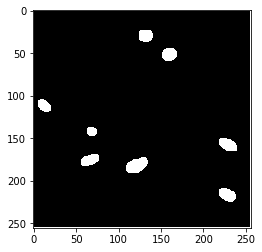

In [364]:
plt.imshow(markers, cmap='gray')

In [423]:
def run_watershed(img, dist_scale=1.0):
    
    if len(img.shape) > 2:
        img = skimage.color.rgb2gray(img)
        
    # Otsu the image
    thresh = filters.threshold_otsu(output)
    img = np.where(img > thresh, 1, 0)
    
    # noise removal
    kernel = np.ones((3,3),np.uint8)
    opening = cv2.morphologyEx(img.astype(np.uint8), cv2.MORPH_OPEN, kernel, iterations = 2)
    
    # sure background area
    sure_bg = cv2.dilate(opening, kernel, iterations=3)
    
    # Finding sure foreground area
    dist_transform = cv2.distanceTransform(opening, cv2.DIST_L2, 5)
    
    # ****the second argument to the threshold here could be a learnable hyperparameter****
    ret, sure_fg = cv2.threshold(dist_transform, dist_scale*dist_transform.mean(), 255, 0)
    
    # Finding unknown region
    sure_fg = np.uint8(sure_fg)
    unknown = cv2.subtract(sure_bg,sure_fg)
    
    # Marker labelling
    ret, markers = cv2.connectedComponents(sure_fg)
    
    # Add one to all labels so that sure background is not 0, but 1
    markers = markers+1
    # Now, mark the region of unknown with zero
    markers[unknown==255] = 0
    
    img_3chan = skimage.color.gray2rgb(img)
    img_3chan = skimage.img_as_ubyte(img_3chan)
    
    # Watershed call
    markers = cv2.watershed(img_3chan, markers)
    img_3chan[markers == -1] = [255,0,0]
    
    markers = np.where(markers == 1, 0, 1)
    return img_3chan, markers

In [424]:
def run_otsu(img):
    gray = skimage.color.rgb2gray(img)
    thresh = skimage.filters.threshold_otsu(gray)
    return (np.where(img > thresh, 1, 0)).astype(np.float32)

## Trying on new image masks from the processed train set (stage 1)

In [425]:
im_number = '2.png'
data_path = 'Data/processed_train/masks/train'
ground_truth = cv2.imread(data_path + im_number)
output = np.load(folder_pth + 'output.npy')

In [426]:
out, water_masks = run_watershed(output)
otsu = run_otsu(output)

/Users/josephmurphy/anaconda/lib/python3.5/site-packages/skimage/util/dtype.py:106: UserWarning: Possible sign loss when converting negative image of type int64 to positive image of type uint8.
  "%s to positive image of type %s." % (dtypeobj_in, dtypeobj))
/Users/josephmurphy/anaconda/lib/python3.5/site-packages/skimage/util/dtype.py:136: UserWarning: Downcasting int64 to uint8 without scaling because max value 1 fits in uint8
  warn(msg)


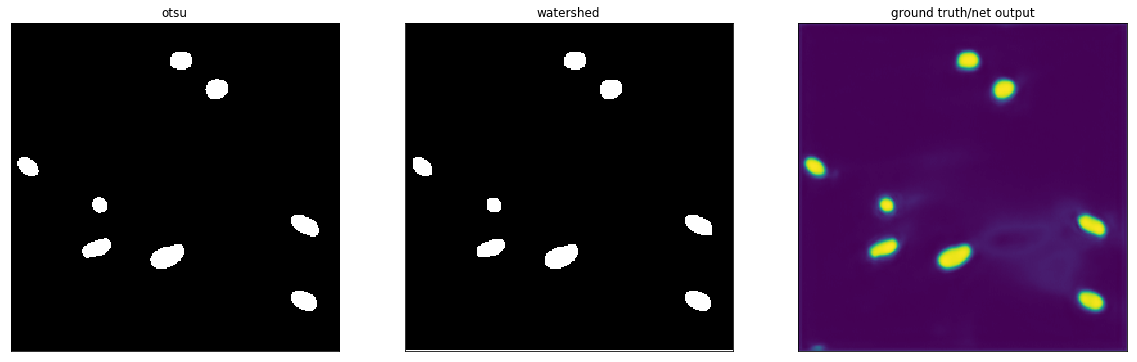

In [428]:
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(20,9))

ax[0].imshow(otsu, cmap='gray')
ax[0].set_title('otsu')

ax[1].imshow(water_masks, cmap='gray')
ax[1].set_title('watershed')

ax[2].imshow(output)
ax[2].set_title('ground truth/net output')

# Turn off ticks and labels
for a in ax:
    a.set_xticks([])
    a.set_yticks([])
    
plt.show()

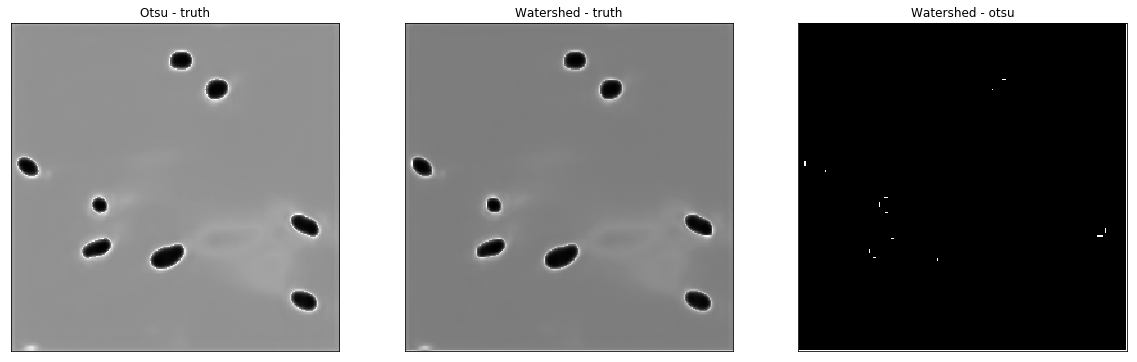

In [436]:
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(20,9))

ax[0].imshow(abs(otsu - output), cmap='gray')
ax[0].set_title('Otsu - truth')

ax[1].imshow(abs(water_masks - output), cmap='gray')
ax[1].set_title('Watershed - truth')

ax[2].imshow(abs(water_masks - otsu), cmap='gray')
ax[2].set_title('Watershed - otsu')

# Turn off ticks and labels
for a in ax:
    a.set_xticks([])
    a.set_yticks([])